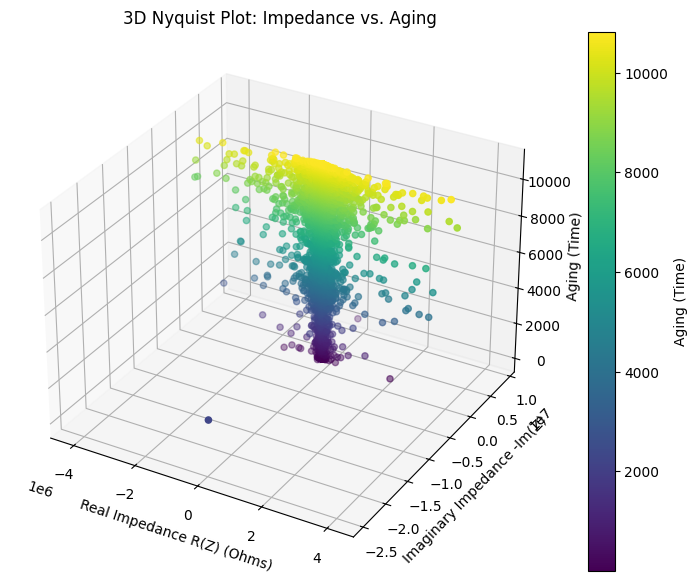

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter  

# Folder containing CSV files
data_folder = "cleaned_data"

# Initialize lists to store impedance data
R_values, Im_values, time_values, capacity_values = [], [], [], []

# Process all CSV files
for filename in sorted(os.listdir(data_folder)):  
    if filename.endswith(".csv"):  
        file_path = os.path.join(data_folder, filename)
        df = pd.read_csv(file_path)
        
        # Ensure necessary columns exist
        required_cols = {"Voltage_measured", "Current_measured", "Time"}
        if not required_cols.issubset(df.columns):
            continue
        
        # Remove near-zero current values
        df = df[df["Current_measured"].abs() > 1e-6]
        
        # Compute Real Impedance (R(Z))
        df["R(Z)"] = df["Voltage_measured"] / df["Current_measured"]
        
        # Apply smoothing
        df["Voltage_measured_smoothed"] = savgol_filter(df["Voltage_measured"], window_length=7, polyorder=3)
        df["Current_measured_smoothed"] = savgol_filter(df["Current_measured"], window_length=7, polyorder=3)
        
        # Compute Imaginary Impedance (Im(Z))
        df["dV"] = np.diff(df["Voltage_measured_smoothed"], prepend=np.nan)
        df["dI"] = np.diff(df["Current_measured_smoothed"], prepend=np.nan)
        df["Im(Z)"] = df["dV"] / df["dI"]

        # Remove invalid values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(subset=["R(Z)", "Im(Z)"], inplace=True)

        # Store values
        R_values.extend(df["R(Z)"].tolist())
        Im_values.extend(df["Im(Z)"].tolist())
        time_values.extend(df["Time"].tolist())

        # If Capacity exists, store it
        if "Capacity" in df.columns:
            capacity_values.extend(df["Capacity"].tolist())

# Save computed data for reuse
impedance_data = pd.DataFrame({
    "R(Z)": R_values,
    "Im(Z)": Im_values,
    "Time": time_values
})

if capacity_values:
    impedance_data["Capacity"] = capacity_values  # Include Capacity if available

impedance_data.to_csv("impedance_data.csv", index=False)

# 3D Nyquist Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with Nyquist convention (-Im(Z) on Y-axis)
scatter = ax.scatter(R_values, -np.array(Im_values), time_values, c=time_values, cmap='viridis')

# Labels
ax.set_xlabel("Real Impedance R(Z) (Ohms)")
ax.set_ylabel("Imaginary Impedance -Im(Z)")
ax.set_zlabel("Aging (Time)")
ax.set_title("3D Nyquist Plot: Impedance vs. Aging")

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Aging (Time)")

plt.show()

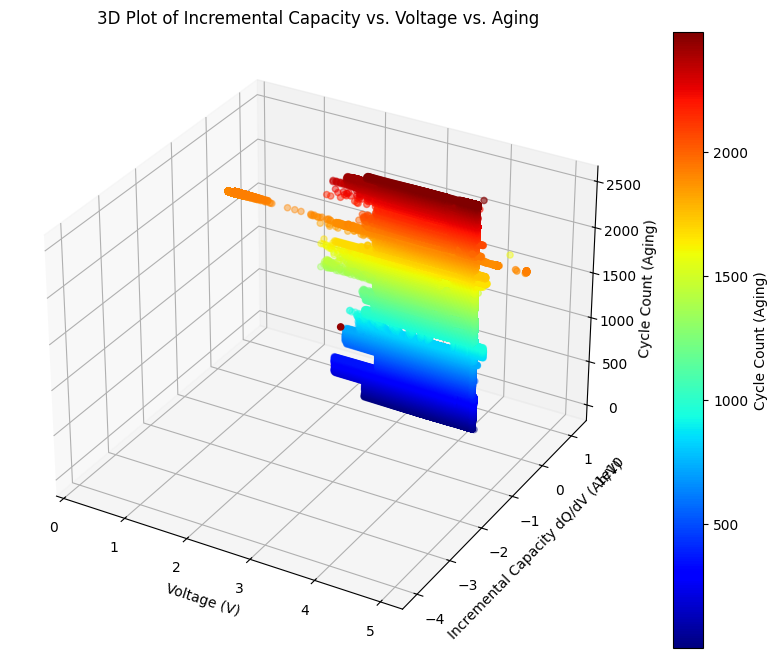

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter

# Folder containing CSV files
data_folder = "cleaned_data"

# Initialize lists to store data
voltage_values, dQ_dV_values, cycle_count_values = [], [], []

# Process all CSV files
for cycle, filename in enumerate(sorted(os.listdir(data_folder))):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_folder, filename)
        df = pd.read_csv(file_path)

        # Ensure necessary columns exist
        if {"Voltage_measured", "Current_measured", "Time"}.issubset(df.columns):
            df = df[df["Current_measured"].abs() > 1e-6]  # Remove near-zero currents

            # Compute Capacity (Q) as cumulative sum of current over time
            df["Capacity"] = np.cumsum(df["Current_measured"].abs())

            # Compute dQ/dV (Incremental Capacity)
            df["dV"] = np.diff(df["Voltage_measured"], prepend=np.nan)
            df["dQ"] = np.diff(df["Capacity"], prepend=np.nan)
            df["dQ/dV"] = df["dQ"] / df["dV"]

            # Remove invalid values
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.dropna(subset=["dQ/dV"], inplace=True)

            # Store values for plotting
            voltage_values.extend(df["Voltage_measured"])
            dQ_dV_values.extend(df["dQ/dV"])
            cycle_count_values.extend([cycle] * len(df))

# Convert to NumPy arrays
voltage_values = np.array(voltage_values)
dQ_dV_values = np.array(dQ_dV_values)
cycle_count_values = np.array(cycle_count_values)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(voltage_values, dQ_dV_values, cycle_count_values, c=cycle_count_values, cmap='jet')

# Labels
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Incremental Capacity dQ/dV (Ah/V)")
ax.set_zlabel("Cycle Count (Aging)")
ax.set_title("3D Plot of Incremental Capacity vs. Voltage vs. Aging")

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Cycle Count (Aging)")

plt.show()

In [3]:
import os
import pandas as pd

data_folder = "cleaned_data"
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".csv")]

unique_columns = set()
for file in all_files:
    df = pd.read_csv(file)
    unique_columns.update(df.columns)

print("Unique column names found in dataset:", unique_columns)

Unique column names found in dataset: {'Voltage_charge', 'test_id', 'Rectified_Impedance', 'type', 'Battery_impedance', 'filename', 'Capacity', 'Current_charge', 'Current_ratio', 'ambient_temperature', 'Current_measured', 'Re', 'Battery_current', 'start_time', 'uid', 'Current_load', 'Temperature_measured', 'Voltage_measured', 'battery_id', 'Time', 'Sense_current', 'Rct', 'Voltage_load'}



 Model Trained! MAE: 920.6310, R²: 0.0004


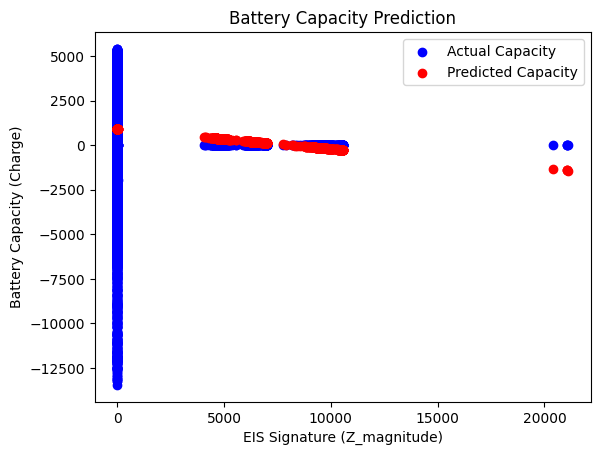

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Load updated dataset
df = pd.read_csv("processed_battery_data_with_EIS.csv")

# Drop rows with NaN values in relevant columns
df = df.dropna(subset=["Z_magnitude", "Charge"])

# Define Features (EIS Signature) and Target (Capacity)
X = df[["Z_magnitude"]]
y = df["Charge"]  # Assuming Charge represents Capacity

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n Model Trained! MAE: {mae:.4f}, R²: {r2:.4f}")

# Plot Actual vs. Predicted Capacity
plt.scatter(X_test, y_test, color='blue', label="Actual Capacity")
plt.scatter(X_test, y_pred, color='red', label="Predicted Capacity")
plt.xlabel("EIS Signature (Z_magnitude)")
plt.ylabel("Battery Capacity (Charge)")
plt.legend()
plt.title("Battery Capacity Prediction")
plt.show()
